# 1. Dependencies

In [3]:
# System.
import os
import glob

# Math.
import numpy as np
import pandas as pd
import statistics as stats

# Plotting.
import matplotlib.pyplot as plt

# 2. Inputs

In [13]:
current_path = os.getcwd()
all_porras_files = glob.glob(os.path.join(current_path + "/data", "*.csv"))

# 3. Cleansing

In [14]:
porras_clean = []
for porra_file in all_porras_files:
    porra = pd.read_csv(porra_file, sep=';', encoding="latin1", header=2)
    
    porra_clean = porra.iloc[:,5:]
    porra_clean = porra_clean[porra_clean.iloc[:,2].notnull()]
    porra_clean = porra_clean.loc[:, ~porra_clean.columns.str.contains('^Unnamed')].T
    porra_clean = porra_clean[(porra_clean.iloc[:,2].notnull()) & (~porra_clean.iloc[:,2].astype(str).str.isdigit())]
    porra_clean.columns = porra_clean.iloc[0]
    porra_clean = porra_clean.drop(porra_clean.index[0])
        
    porras_clean.append(porra_clean)

porras_clean = pd.concat(porras_clean, axis=0, ignore_index=True)
porras_clean.reset_index(drop=True, inplace=True)
porras_clean

?? Resultados reales ??,Senegal-Paises Bajos,Catar-Ecuador,Inglaterra-Irán,Estados unidos-Gales,Argentina-Arabia Saudita,México-Polonia,Dinamarca-Túnez,Francia-Australia,Alemania-Japón,España-Costa Rica,...,W61-W62,Campeón,Subcampeón,3º Clasificado,Bota de Oro (máximo goleador),Bota de Plata (2º máximo goleador),Bota de Bronce (3º máximo goleador),Balón de Oro (mejor jugador),Balón de Plata (2º mejor jugador),Balón de Bronce (3º mejor jugador)
0,2|0-2,X|0-0,1|2-0,X|1-1,1|3-0,X|1-1,X|1-1,1|2-0,1|1-0,1|2-1,...,Argentina-España·1|3-1,Argentina,España,Francia,Messi,Gabriel Jesús,Vinicius,Messi,Pedri,Neymar
1,2|0-2,1|1-0,1|3-1,2|1-2,1|4-0,2|0-2,1|3-1,1|2-1,1|2-0,1|1-0,...,Brasil-Francia·1|3-2,Brasil,Francia,Argentina,Vinicius,Messi,Harry Kane,Vinicius,Mbappé,Messi
2,2|0-2,X|1-1,1|2-0,1|2-1,1|2-0,1|2-1,1|1-0,1|2-1,1|2-0,X|1-1,...,Brasil-Francia·1|2-0,Brasil,Francia,Argentina,Mbappé,Rodrygo,Lukaku,Vinicius,Mbappé,De Bruyne
3,2|0-2,X|0-0,1|3-0,X|1-1,1|2-0,X|1-1,1|1-0,1|2-0,1|2-0,1|1-0,...,Brasil-Inglaterra·1|1-0,Brasil,Inglaterra,Argentina,Harry Kane,Gabriel Jesús,Mbappé,Neymar,Harry Kane,Messi
4,2|1-2,2|0-2,1|2-0,X|1-1,1|2-0,2|1-2,1|2-0,1|2-0,1|2-0,1|3-0,...,Brasil-Francia·X|1-1,Brasil,Francia,Argentina,Neymar,Messi,Mbappé,Messi,Neymar,Mbappé
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
80,2|0-2,1|1-0,1|2-0,X|1-1,1|3-0,X|1-1,X|1-1,1|2-0,1|2-0,1|2-0,...,Brasil-Francia·1|2-0,Brasil,Francia,Argentina,Mbappé,Kane,Vlahovic,Messi,Neymar,Griezmann
81,2|1-3,X|1-1,1|4-1,X|1-1,1|5-1,X|2-2,1|2-0,1|3-0,1|2-1,1|3-1,...,Argentina-Inglaterra·1|2-1,Argentina,Inglaterra,España,Kane,Messi,Gabriel Jesús,Messi,Neymar,Mbappé
82,2|0-2,X|1-1,1|3-0,X|1-1,1|3-0,1|2-1,1|2-0,1|2-0,1|2-1,1|1-0,...,Brasil-Francia·1|2-1,Brasil,Francia,España,Neymar,Benzema,Messi,Neymar,Benzema,Messi
83,2|0-1,X|0-0,1|3-0,1|3-2,1|3-0,2|1-2,1|2-1,2|0-1,1|4-0,1|1-0,...,Argentina-Inglaterra·1|3-1,Argentina,Inglaterra,Brasil,Leo Messi,Neymar,Harry Kane,Leo Messi,Neymar,Cristiano Ronaldo


# 4. Processing

## 4.1. Grupos

In [126]:
target_iqr = 1.5

porras_grupos = porras_clean.copy().iloc[:,:48]

porras_grupos_results = {}
for match in porras_grupos:
    match_data = porras_grupos.loc[:, match].str[2:].str.split('-', 1, expand=True)
    
    porras_grupos_results[match] = {}
    for side in range(2):
        match_data_side_sort = pd.to_numeric(match_data.sort_values(by=[side], ascending=True)[side])
        
        q1 = match_data_side_sort.quantile(0.25)
        q3 = match_data_side_sort.quantile(0.75)
        iqr = q3 - q1
        iqr_limit_down = q1 - iqr * target_iqr
        iqr_limit_up = q3 + iqr * target_iqr
 
        porras_grupos_results[match]["outliers_" + str(side + 1)] = len(match_data_side_sort[(match_data_side_sort < iqr_limit_down) | (match_data_side_sort > iqr_limit_up)])
        match_data_side_nout = match_data_side_sort[(match_data_side_sort >= iqr_limit_down) & (match_data_side_sort <= iqr_limit_up)]
        porras_grupos_results[match]["median_" + str(side + 1)] = np.quantile(match_data_side_nout, 0.5, method='lower')
        porras_grupos_results[match]["mean_" + str(side + 1)] = round(match_data_side_nout.mean())
        porras_grupos_results[match]["std_" + str(side + 1)] = match_data_side_nout.std()
        porras_grupos_results[match]["mode_" + str(side + 1)] = stats.mode(match_data_side_nout)
        
porras_grupos_results = pd.DataFrame.from_dict(porras_grupos_results, orient='index')

conditions = [
        (porras_grupos_results['median_1'] > porras_grupos_results['median_2']),
        (porras_grupos_results['median_1'] < porras_grupos_results['median_2']),
        (porras_grupos_results['median_1'] == porras_grupos_results['median_2'])
    ]
values = ['1', '2', 'X']
porras_grupos_results['predicted_result'] = np.select(conditions, values)
porras_grupos_results['predicted_result'] = porras_grupos_results['predicted_result'] + '|' + porras_grupos_results['median_1'].astype(str) + '-' + porras_grupos_results['median_2'].astype(str)
porras_grupos_results

porras_grupos_results

,outliers_1,median_1,mean_1,std_1,mode_1,outliers_2,median_2,mean_2,std_2,mode_2,predicted_result
Senegal-Paises Bajos,0,1,1,0.632898,1,31,2,2,0.000000,2,2|1-2
Catar-Ecuador,0,1,1,0.605067,1,0,1,1,0.810989,1,X|1-1
Inglaterra-Irán,3,3,3,0.737436,3,0,0,0,0.452816,0,1|3-0
Estados unidos-Gales,0,1,1,0.661676,1,26,1,1,0.000000,1,X|1-1
Argentina-Arabia Saudita,3,3,3,0.730977,3,14,0,0,0.000000,0,1|3-0
México-Polonia,0,1,1,0.649283,1,0,1,1,0.782333,1,X|1-1
Dinamarca-Túnez,2,2,2,0.658139,2,0,0,0,0.511219,0,1|2-0
Francia-Australia,4,3,3,0.783708,3,0,0,0,0.472789,0,1|3-0
Alemania-Japón,27,2,2,0.000000,2,0,1,1,0.624433,0,1|2-1
España-Costa Rica,1,2,2,0.752125,2,0,0,0,0.480721,0,1|2-0


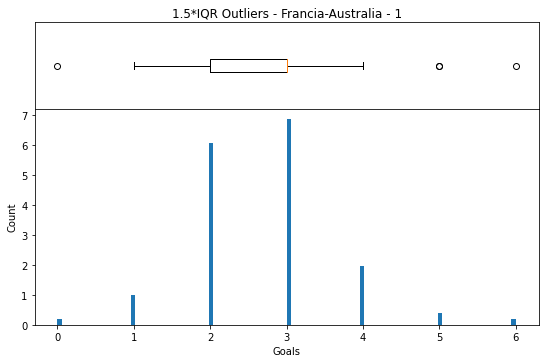

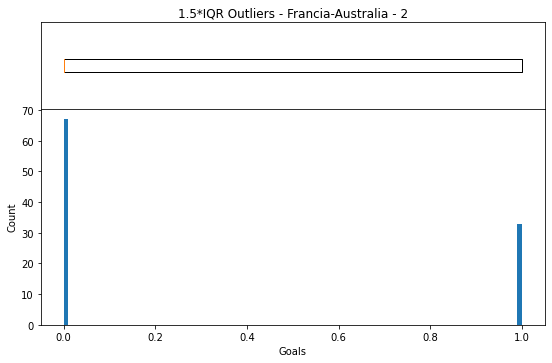

In [8]:
match = "Francia-Australia"

porras_grupos = porras_clean.copy().iloc[:,:48]

match_data = porras_grupos.loc[:, match].str[2:].str.split('-', 1, expand=True)
for side in range(2):
    match_data_side_sort = pd.to_numeric(match_data.sort_values(by=[side], ascending=True)[side])       
    
    fig = plt.figure(figsize=(10, 6))

    bpAx = fig.add_axes([0.2, 0.7, 0.7, 0.2]) 
    histAx = fig.add_axes([0.2, 0.2, 0.7, 0.5]) 

    bp = bpAx.boxplot(match_data_side_sort, vert=False, whis = target_iqr)
    h = histAx.hist(match_data_side_sort, bins=100, density=True)

    xlims = np.array([bpAx.get_xlim(), histAx.get_xlim()])
    for ax in [bpAx, histAx]:
        ax.set_xlim([xlims.min(), xlims.max()])

    bpAx.set_xticklabels([])  
    bpAx.set_yticks([])  
    bpAx.set_title(str(target_iqr) + "*IQR Outliers - " + str(match) + " - " + str(side + 1))
    histAx.set_xlabel('Goals')
    histAx.set_ylabel('Count')
    plt.show()

## 4.2. Octavos

In [11]:
target_iqr = 1.5

porras_octavos = porras_clean.copy().iloc[:,96:104]

porras_octavos_results = {}
porras_team_goals = pd.DataFrame(columns=['team', 'goals'])
for match in porras_octavos:
    for side in range(2):
        porras_octavos['team'] = porras_octavos[match].str.split('·', expand=True)[0].str.split('-', expand=True)[side]
        porras_octavos['goals'] = porras_octavos[match].str.split('·', expand=True)[1].str.split('|', expand=True)[1].str.split('-', expand=True)[side]
        porras_team_goals = pd.concat([porras_team_goals, porras_octavos[['team', 'goals']]], axis=0)
        
unique_teams = porras_team_goals['team'].unique()
for team in unique_teams:
    porras_octavos_results[team] = {}
    team_data_sort = pd.to_numeric(porras_team_goals[porras_team_goals['team'] == team].sort_values(by=['goals'], ascending=True)['goals'])
    
    q1 = team_data_sort.quantile(0.25)
    q3 = team_data_sort.quantile(0.75)
    iqr = q3 - q1
    iqr_limit_down = q1 - iqr * target_iqr
    iqr_limit_up = q3 + iqr * target_iqr
    
    team_data_nout = team_data_sort[(team_data_sort >= iqr_limit_down) & (team_data_sort <= iqr_limit_up)]
    porras_octavos_results[team]["median"] = np.quantile(team_data_nout, 0.5, method='lower')
    porras_octavos_results[team]["mean"] = round(team_data_nout.mean())
    porras_octavos_results[team]["std"] = team_data_nout.std()
    porras_octavos_results[team]["mode"] = stats.mode(team_data_nout)

porras_octavos_results = pd.DataFrame.from_dict(porras_octavos_results, orient='index')
porras_octavos_results

,median,mean,std,mode
Paises Bajos,2,2,0.000000,2
Senegal,0,1,0.761533,0
Inglaterra,2,2,0.000000,2
Gales,1,1,0.546955,1
Estados unidos,1,1,0.551066,1
Argentina,2,2,0.746232,2
Polonia,1,1,0.600812,1
México,1,1,0.659514,1
Dinamarca,1,1,0.653381,1
Australia,0,0,0.534522,0


## 4.3. Cuartos

In [25]:
target_iqr = 1.5

porras_octavos = porras_clean.copy().iloc[:,112:116]

porras_octavos_results = {}
porras_team_goals = pd.DataFrame(columns=['team', 'goals'])
for match in porras_octavos:
    for side in range(2):
        porras_octavos['team'] = porras_octavos[match].str.split('·', expand=True)[0].str.split('-', expand=True)[side]
        porras_octavos['goals'] = porras_octavos[match].str.split('·', expand=True)[1].str.split('|', expand=True)[1].str.split('-', expand=True)[side]
        porras_team_goals = pd.concat([porras_team_goals, porras_octavos[['team', 'goals']]], axis=0)
        
unique_teams = porras_team_goals['team'].unique()
unique_teams = unique_teams[~(pd.isnull(unique_teams))]
for team in unique_teams:
    porras_octavos_results[team] = {}
    team_data_sort = pd.to_numeric(porras_team_goals[porras_team_goals['team'] == team].sort_values(by=['goals'], ascending=True)['goals'])
    q1 = team_data_sort.quantile(0.25)
    q3 = team_data_sort.quantile(0.75)
    iqr = q3 - q1
    iqr_limit_down = q1 - iqr * target_iqr
    iqr_limit_up = q3 + iqr * target_iqr
    
    team_data_nout = team_data_sort[(team_data_sort >= iqr_limit_down) & (team_data_sort <= iqr_limit_up)]
    porras_octavos_results[team]["median"] = np.quantile(team_data_nout, 0.5, method='lower')
    porras_octavos_results[team]["mean"] = team_data_nout.mean()
    porras_octavos_results[team]["mean_round"] = round(team_data_nout.mean())
    porras_octavos_results[team]["std"] = team_data_nout.std()
    porras_octavos_results[team]["mode"] = stats.mode(team_data_nout)

porras_octavos_results = pd.DataFrame.from_dict(porras_octavos_results, orient='index')
display(porras_octavos_results)    

,median,mean,mean_round,std,mode
Alemania,1,1.171875,1,0.724945,1
España,1,1.231884,1,0.667412,1
Croacia,1,1.272727,1,1.103713,1
Bélgica,1,1.200000,1,0.707107,1
Brasil,2,2.263158,2,0.789404,2
Suiza,1,0.666667,1,0.577350,1
Portugal,1,1.127660,1,0.797197,1
Paises Bajos,1,0.763158,1,0.709336,1
Senegal,1,1.333333,1,0.516398,1
Estados unidos,0,0.500000,0,0.577350,0


## 4.4. Semis

In [31]:
target_iqr = 1.5

porras_octavos = porras_clean.copy().iloc[:,120:122]

porras_octavos_results = {}
porras_team_goals = pd.DataFrame(columns=['team', 'goals'])
for match in porras_octavos:
    for side in range(2):
        porras_octavos['team'] = porras_octavos[match].str.split('·', expand=True)[0].str.split('-', expand=True)[side]
        porras_octavos['goals'] = porras_octavos[match].str.split('·', expand=True)[1].str.split('|', expand=True)[1].str.split('-', expand=True)[side]
        porras_team_goals = pd.concat([porras_team_goals, porras_octavos[['team', 'goals']]], axis=0)
        
unique_teams = porras_team_goals['team'].unique()
unique_teams = unique_teams[~(pd.isnull(unique_teams))]
for team in unique_teams:
    porras_octavos_results[team] = {}
    team_data_sort = pd.to_numeric(porras_team_goals[porras_team_goals['team'] == team].sort_values(by=['goals'], ascending=True)['goals'])
    q1 = team_data_sort.quantile(0.25)
    q3 = team_data_sort.quantile(0.75)
    iqr = q3 - q1
    iqr_limit_down = q1 - iqr * target_iqr
    iqr_limit_up = q3 + iqr * target_iqr
    
    team_data_nout = team_data_sort[(team_data_sort >= iqr_limit_down) & (team_data_sort <= iqr_limit_up)]
    porras_octavos_results[team]["median"] = np.quantile(team_data_nout, 0.5, method='lower')
    porras_octavos_results[team]["mean"] = team_data_nout.mean()
    porras_octavos_results[team]["mean_round"] = round(team_data_nout.mean())
    porras_octavos_results[team]["std"] = team_data_nout.std()
    porras_octavos_results[team]["mode"] = stats.mode(team_data_nout)

porras_octavos_results = pd.DataFrame.from_dict(porras_octavos_results, orient='index')
display(porras_octavos_results)    

,median,mean,mean_round,std,mode
Argentina,1,1.473684,1,0.944792,1
Polonia,1,1.000000,1,0.000000,1
Francia,2,1.530612,2,0.766541,2
Paises Bajos,0,0.750000,1,0.957427,0
Inglaterra,1,1.400000,1,0.723974,1
Senegal,0,0.500000,0,0.707107,0
Dinamarca,1,0.800000,1,0.836660,0
Brasil,2,1.805970,2,0.763541,2
Alemania,1,1.150000,1,1.136708,0
Portugal,1,0.611111,1,0.607685,1


## 4.5. Tercer y cuarto

In [43]:
target_iqr = 1.5

porras_octavos = porras_clean.copy().iloc[:,126:127]

porras_octavos_results = {}
porras_team_goals = pd.DataFrame(columns=['team', 'goals'])
for match in porras_octavos:
    for side in range(2):
        porras_octavos['team'] = porras_octavos[match].str.split('·', expand=True)[0].str.split('-', expand=True)[side]
        porras_octavos['goals'] = porras_octavos[match].str.split('·', expand=True)[1].str.split('|', expand=True)[1].str.split('-', expand=True)[side]
        porras_team_goals = pd.concat([porras_team_goals, porras_octavos[['team', 'goals']]], axis=0)
        
unique_teams = porras_team_goals['team'].unique()
unique_teams = unique_teams[~(pd.isnull(unique_teams))]
for team in unique_teams:
    porras_octavos_results[team] = {}
    team_data_sort = pd.to_numeric(porras_team_goals[porras_team_goals['team'] == team].sort_values(by=['goals'], ascending=True)['goals'])
    q1 = team_data_sort.quantile(0.25)
    q3 = team_data_sort.quantile(0.75)
    iqr = q3 - q1
    iqr_limit_down = q1 - iqr * target_iqr
    iqr_limit_up = q3 + iqr * target_iqr
    
    team_data_nout = team_data_sort[(team_data_sort >= iqr_limit_down) & (team_data_sort <= iqr_limit_up)]
    porras_octavos_results[team]["median"] = np.quantile(team_data_nout, 0.5, method='lower')
    porras_octavos_results[team]["mean"] = team_data_nout.mean()
    porras_octavos_results[team]["mean_round"] = round(team_data_nout.mean())
    porras_octavos_results[team]["std"] = team_data_nout.std()
    porras_octavos_results[team]["mode"] = stats.mode(team_data_nout)

porras_octavos_results = pd.DataFrame.from_dict(porras_octavos_results, orient='index')
display(porras_octavos_results)    

,median,mean,mean_round,std,mode
Brasil,3,2.200000,2,1.190238,3
Argentina,2,1.465116,1,0.984374,2
Alemania,1,1.181818,1,0.981650,1
Polonia,2,2.000000,2,0.000000,2
Francia,2,1.769231,2,0.438529,2
España,2,1.722222,2,1.017815,1
Paises Bajos,1,1.333333,1,0.577350,1
Inglaterra,2,1.600000,2,0.547723,2
Senegal,1,1.000000,1,0.000000,1
Dinamarca,1,1.000000,1,0.000000,1


## 4.6. Final

In [44]:
target_iqr = 1.5

porras_octavos = porras_clean.copy().iloc[:,127:128]

porras_octavos_results = {}
porras_team_goals = pd.DataFrame(columns=['team', 'goals'])
for match in porras_octavos:
    for side in range(2):
        porras_octavos['team'] = porras_octavos[match].str.split('·', expand=True)[0].str.split('-', expand=True)[side]
        porras_octavos['goals'] = porras_octavos[match].str.split('·', expand=True)[1].str.split('|', expand=True)[1].str.split('-', expand=True)[side]
        porras_team_goals = pd.concat([porras_team_goals, porras_octavos[['team', 'goals']]], axis=0)
        
unique_teams = porras_team_goals['team'].unique()
unique_teams = unique_teams[~(pd.isnull(unique_teams))]
for team in unique_teams:
    porras_octavos_results[team] = {}
    team_data_sort = pd.to_numeric(porras_team_goals[porras_team_goals['team'] == team].sort_values(by=['goals'], ascending=True)['goals'])
    q1 = team_data_sort.quantile(0.25)
    q3 = team_data_sort.quantile(0.75)
    iqr = q3 - q1
    iqr_limit_down = q1 - iqr * target_iqr
    iqr_limit_up = q3 + iqr * target_iqr
    
    team_data_nout = team_data_sort[(team_data_sort >= iqr_limit_down) & (team_data_sort <= iqr_limit_up)]
    porras_octavos_results[team]["median"] = np.quantile(team_data_nout, 0.5, method='lower')
    porras_octavos_results[team]["mean"] = team_data_nout.mean()
    porras_octavos_results[team]["mean_round"] = round(team_data_nout.mean())
    porras_octavos_results[team]["std"] = team_data_nout.std()
    porras_octavos_results[team]["mode"] = stats.mode(team_data_nout)

porras_octavos_results = pd.DataFrame.from_dict(porras_octavos_results, orient='index')
display(porras_octavos_results)    

,median,mean,mean_round,std,mode
Argentina,2,1.741935,2,0.929794,2
Brasil,2,1.853659,2,0.792495,2
Portugal,1,1.500000,2,0.707107,1
España,1,1.000000,1,0.000000,1
Paises Bajos,2,2.000000,2,NaN,2
Alemania,1,1.222222,1,1.301708,0
Francia,1,1.382353,1,0.888127,1
Inglaterra,1,1.000000,1,0.000000,1
Uruguay,1,1.500000,2,1.290994,0
Bélgica,0,0.500000,0,0.707107,0


In [46]:
porras_cuadrohonor = porras_clean.copy().iloc[:,131:]

porras_cuadrohonor_results = {}
for prize in porras_cuadrohonor:
    porras_cuadrohonor_results[prize] = porras_cuadrohonor.groupby(prize).size().sort_values(ascending=False)[:5].index
        
porras_cuadrohonor_results = pd.DataFrame.from_dict(porras_cuadrohonor_results)
porras_cuadrohonor_results

,Bota de Oro (máximo goleador),Bota de Plata (2º máximo goleador),Bota de Bronce (3º máximo goleador),Balón de Oro (mejor jugador),Balón de Plata (2º mejor jugador),Balón de Bronce (3º mejor jugador)
0,Mbappé,Messi,Neymar,Messi,Neymar,Messi
1,Messi,Neymar,Harry Kane,Neymar,Messi,Mbappé
2,Harry Kane,Mbappé,Mbappé,Mbappé,Mbappé,Neymar
3,Neymar,Harry Kane,Vinicius,Leo Messi,Benzema,Harry Kane
4,Benzema,Ansu Fati,Messi,Benzema,Pedri,De Bruyne
